<a href="https://colab.research.google.com/github/muhnasih/PCVK_GANJIL_2025/blob/main/week6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Gambar terbaca dengan ukuran: (512, 512)


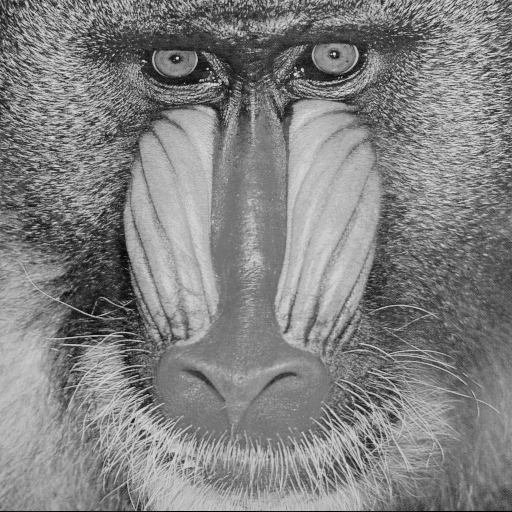

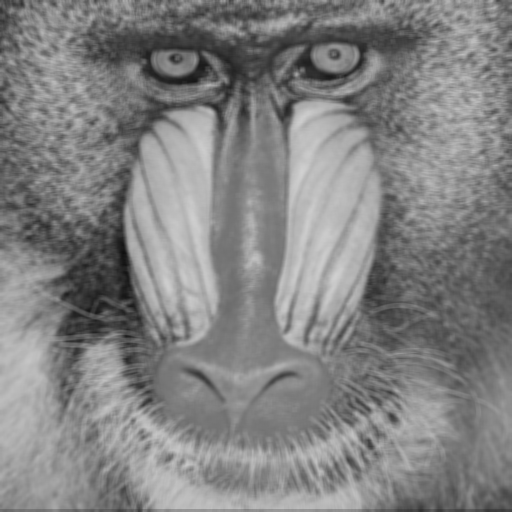

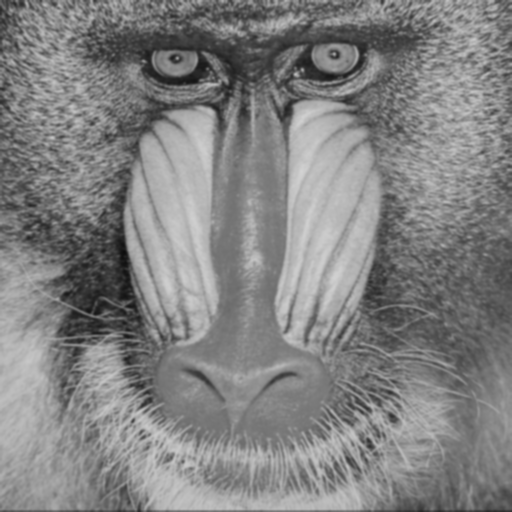

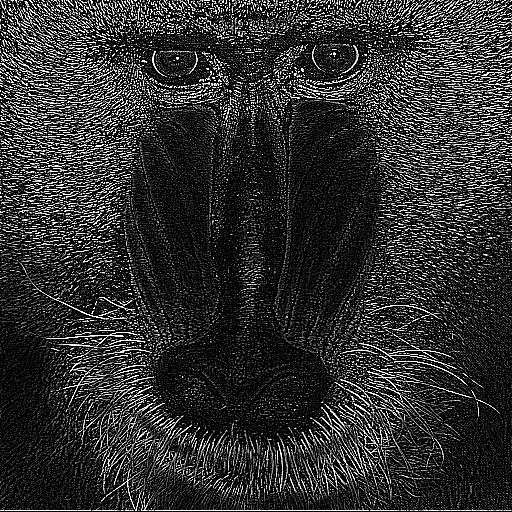

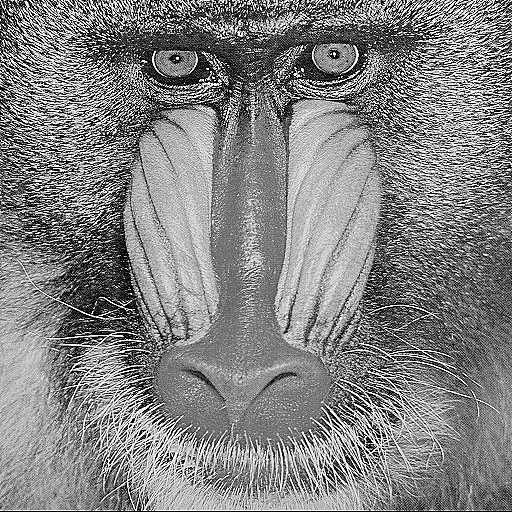

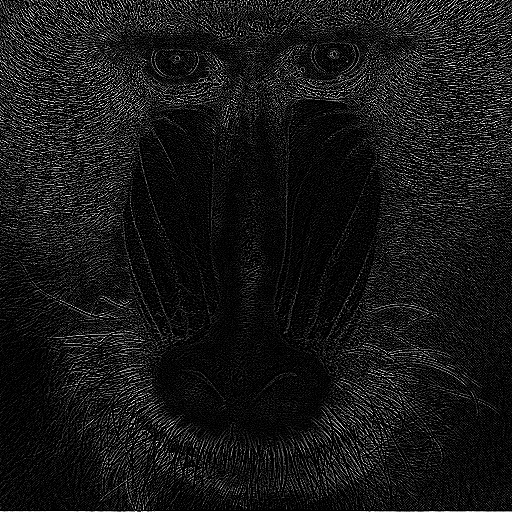

In [13]:
import cv2 as cv
import numpy as np
from google.colab.patches import cv2_imshow
from google.colab import drive

# Mount Google Drive (jika pakai Colab)
drive.mount('/content/drive')

# Path gambar (ganti sesuai lokasi file kamu)
img_path = '/content/drive/MyDrive/Image/mandrill.tiff'
img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)

if img is None:
    print("❌ Gagal membaca gambar. Periksa path:", img_path)
else:
    print("✅ Gambar terbaca dengan ukuran:", img.shape)

    # 1. Average Filter (Mean filter)
    kernel_avg = np.ones((5,5), np.float32) / 25
    avg_filtered = cv.filter2D(img, -1, kernel_avg)

    # 2. Low Pass Filter (Gaussian Blur)
    lowpass = cv.GaussianBlur(img, (5,5), 0)

    # 3. High Pass Filter (Edge detection pakai Laplacian kernel)
    kernel_highpass = np.array([[-1,-1,-1],
                                [-1, 8,-1],
                                [-1,-1,-1]])
    highpass = cv.filter2D(img, -1, kernel_highpass)

    # 4. Sharpening Filter
    kernel_sharpen = np.array([[0,-1,0],
                               [-1,5,-1],
                               [0,-1,0]])
    sharpened = cv.filter2D(img, -1, kernel_sharpen)

    # 5. Laplacian Filter (untuk deteksi tepi)
    laplacian = cv.Laplacian(img, cv.CV_64F)

    # Tampilkan hasil
    cv2_imshow(img)              # original
    cv2_imshow(avg_filtered)     # average
    cv2_imshow(lowpass)          # low pass (blur)
    cv2_imshow(highpass)         # high pass (edges)
    cv2_imshow(sharpened)        # sharpened
    cv2_imshow(laplacian)        # laplacian


**E. FILTER LIBRARY DAN FILTER MODERN**

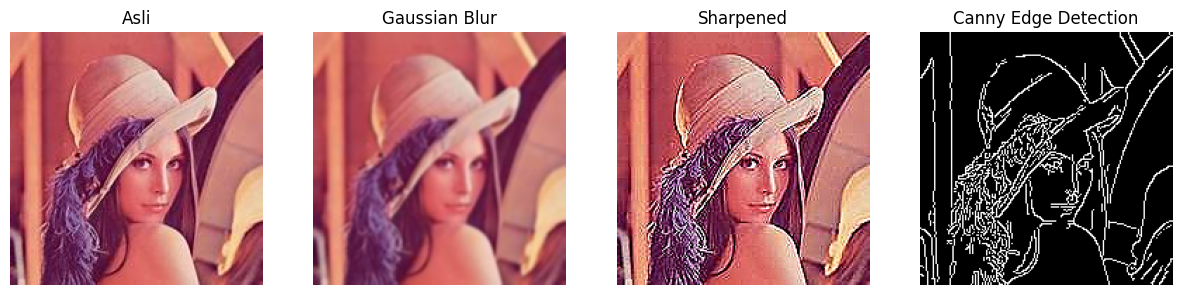

In [19]:
# Fungsi tampil berdampingan
def show_side_by_side(images, titles, figsize=(15,5)):
    plt.figure(figsize=figsize)
    for i, (img, title) in enumerate(zip(images, titles)):
        if len(img.shape) == 2:  # grayscale
            plt.subplot(1, len(images), i+1)
            plt.imshow(img, cmap="gray")
        else:  # color
            plt.subplot(1, len(images), i+1)
            plt.imshow(cv.cvtColor(img, cv.COLOR_BGR2RGB))
        plt.title(title)
        plt.axis("off")
    plt.show()

img = cv.imread("/content/drive/MyDrive/Image/lenna.jpeg")
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

blur = cv.GaussianBlur(img, (7,7), 1)
edges = cv.Canny(cv.cvtColor(img, cv.COLOR_BGR2GRAY), 100, 200)
sharpen_kernel = np.array([[0,-1,0],[-1,5,-1],[0,-1,0]])
sharpened = cv.filter2D(img, -1, sharpen_kernel)

show_side_by_side(
    [img, blur, sharpened, edges],
    ["Asli", "Gaussian Blur", "Sharpened", "Canny Edge Detection"]
)


**Percobaan 2:**

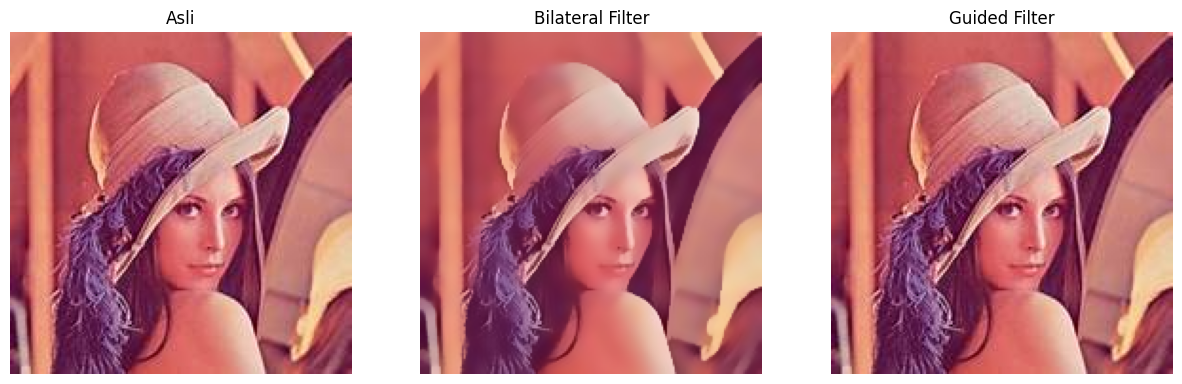

In [21]:
import cv2 as cv
import matplotlib.pyplot as plt

# Baca gambar
img = cv.imread("/content/drive/MyDrive/lenna.jpeg")

# Bilateral Filtering
bilateral = cv.bilateralFilter(img, d=9, sigmaColor=75, sigmaSpace=75)

# Guided Filtering (butuh opencv-contrib)
import cv2.ximgproc as xip
guided = xip.guidedFilter(guide=img, src=img, radius=8, eps=0.04)

# Tampilkan hasil
titles = ["Asli", "Bilateral Filter", "Guided Filter"]
images = [img, bilateral, guided]

plt.figure(figsize=(15,5))
for i in range(3):
    plt.subplot(1,3,i+1)
    plt.imshow(cv.cvtColor(images[i], cv.COLOR_BGR2RGB))
    plt.title(titles[i])
    plt.axis("off")
plt.show()


**Percobaan 3:**

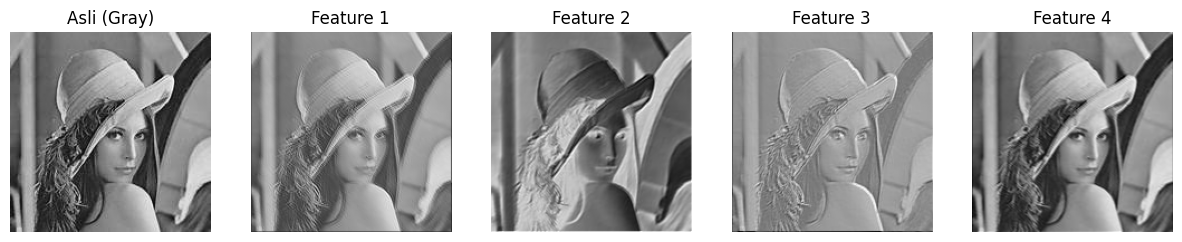

In [22]:
# Filter Feature Map yang digunakan pada CNN, Lakukan running code bagian ini beberapa kali dan perhatikan hasilnya
import torch
import torch.nn as nn

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        return self.conv1(x)

model = SimpleCNN()

# Ubah gambar ke tensor
img_tensor = torch.tensor(img_gray, dtype=torch.float32).unsqueeze(0).unsqueeze(0) / 255.0

# Hasil CNN
with torch.no_grad():
    features = model(img_tensor)

# Visualisasi feature maps
feature_maps = [features[0, i].numpy() for i in range(features.shape[1])]
show_side_by_side([img_gray] + feature_maps, ["Asli (Gray)"] + [f"Feature {i+1}" for i in range(len(feature_maps))])


**Percobaan 4:**

In [25]:
# ==================
# 1. Beauty Filter
# ==================

# Step 1: Smoothing kulit dengan bilateral filter
smooth = cv.bilateralFilter(img, d=15, sigmaColor=75, sigmaSpace=75)

# Step 2: Unsharp masking (pertajam mata/bibir)
gaussian = cv.GaussianBlur(smooth, (0,0), 3)
sharpened = cv.addWeighted(smooth, 1.5, gaussian, -0.5, 0)

# Step 3: Brightness & contrast
alpha = 1.2   # contrast
beta = 15     # brightness
beauty = cv.convertScaleAbs(sharpened, alpha=alpha, beta=beta)


# ==================
# 2. Old/Vintage Filter
# ==================

# Step 1: Sepia tone
sepia_kernel = np.array([[0.272, 0.534, 0.131],
                         [0.349, 0.686, 0.168],
                         [0.393, 0.769, 0.189]])

sepia = cv.transform(img, sepia_kernel)
sepia = np.clip(sepia, 0, 255).astype(np.uint8)

# Step 2: Vignette
rows, cols = img.shape[:2]
kernel_x = cv.getGaussianKernel(cols, cols*0.6)
kernel_y = cv.getGaussianKernel(rows, rows*0.6)
kernel = kernel_y * kernel_x.T
mask = kernel / kernel.max()
vignette = np.copy(sepia)
for i in range(3):
    vignette[:,:,i] = vignette[:,:,i] * mask

# Step 3: Noise/Grain
noise = np.random.normal(0, 15, vignette.shape).astype(np.int16)
old_img = np.clip(vignette.astype(np.int16) + noise, 0, 255).astype(np.uint8)


**Percobaan 5:**

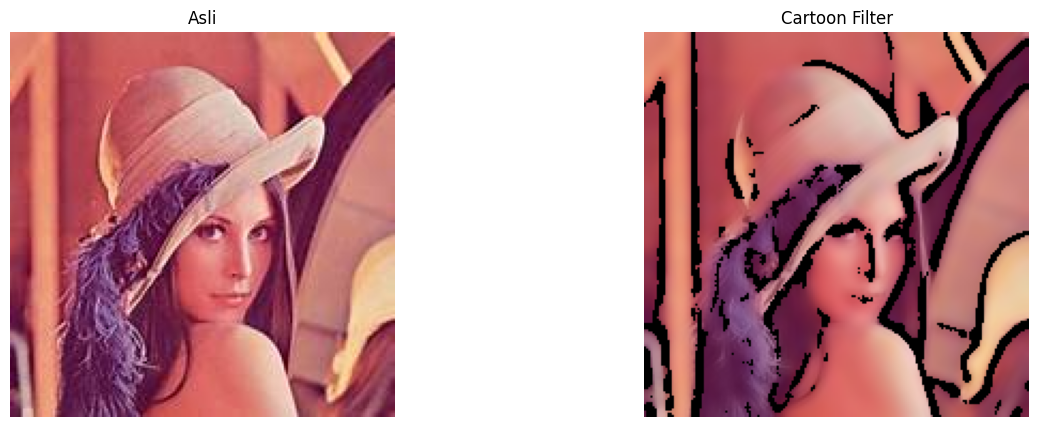

In [26]:
# Filter Anime / Cartoon

# Step 1: Edge detection (pakai median blur dulu agar gambar menjadi lebih halus)
gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
gray_blur = cv.medianBlur(gray, 7)
edges = cv.adaptiveThreshold(gray_blur, 255,
                             cv.ADAPTIVE_THRESH_MEAN_C,
                             cv.THRESH_BINARY, 9, 9)

# Step 2: Bilateral filter untuk smoothing warna
color = cv.bilateralFilter(img, d=9, sigmaColor=200, sigmaSpace=200)

# Step 3: Gabungkan (cartoonize)
cartoon = cv.bitwise_and(color, color, mask=edges)

# Tampilkan
show_side_by_side([img, cartoon], ["Asli", "Cartoon Filter"])


**Percobaan 6:**

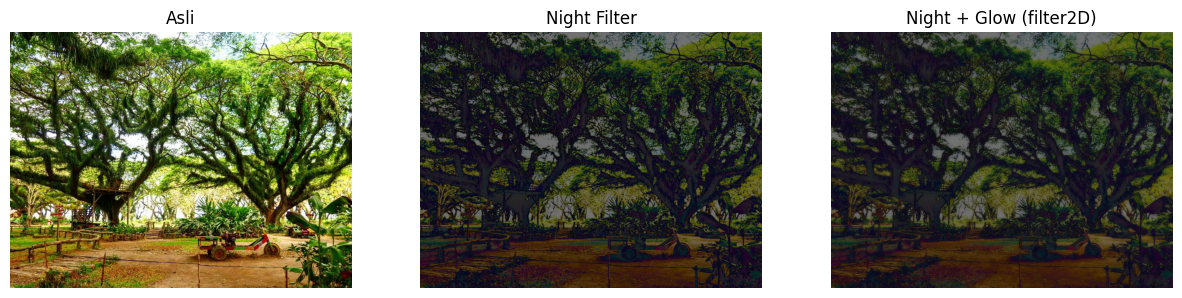

In [27]:
# Night Filter
img = cv.imread("/content/drive/MyDrive/Image/djawatan.jpg")
img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

# Step 1: Gelapkan (contrast turun, brightness negatif)
night = cv.convertScaleAbs(img, alpha=0.6, beta=-40)

# Step 2: Tambah bias biru
blue_tint = np.full_like(night, (50, 0, 100))   # BGR
cv.addWeighted(night, 0.8, blue_tint, 0.2, 0)

# Step 3: Efek glow di area terang dengan filter2D (blur kernel)
kernel = np.ones((15,15), np.float32) / 225
glow = cv.filter2D(night, -1, kernel)

# Kombinasikan asli + glow
night_glow = cv.addWeighted(night, 0.7, glow, 0.3, 0)

show_side_by_side([img, night, night_glow],
                  ["Asli", "Night Filter", "Night + Glow (filter2D)"])


**Percobaan 7**

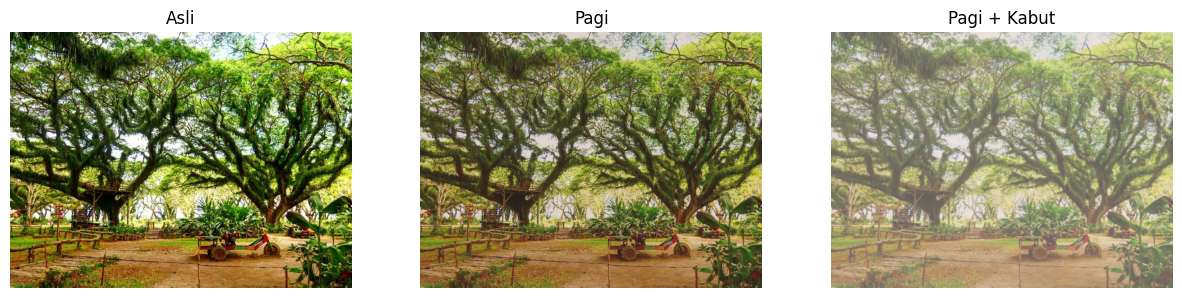

In [28]:
# Filter Suasana pagi dan Kabut
# ============================
# Step 1: Kurangi kontras & cerahkan
# ============================
alpha = 0.9     # contrast
beta = 20       # brightness
soft = cv.convertScaleAbs(img, alpha=alpha, beta=beta)


# ============================
# Step 2: Tambahkan warm tone (kemerahan / oranye)
# ============================
warm_tint = np.full_like(soft, (40, 70, 120))   # BGR
pagi = cv.addWeighted(soft, 0.8, warm_tint, 0.2, 0)


# ============================
# Step 3: Tambahkan haze (kabut tipis) dengan filter2D
# ============================
# Kernel blur Gaussian-Like untuk menciptakan efek kabut
kernel = cv.getGaussianKernel(3, 3)
kernel = kernel @ kernel.T   # jadikan 2D kernel
kabut = cv.filter2D(pagi, -1, kernel)

# tambah layer putih untuk kabut lebih nyata
white_layer = np.full_like(pagi, 255)
kabut = cv.addWeighted(kabut, 0.7, white_layer, 0.3, 0)

show_side_by_side([img, pagi, kabut],
                  ["Asli", "Pagi", "Pagi + Kabut"])
